<a href="https://colab.research.google.com/github/Ruanvans/ECG-classification-using-deep-learning/blob/master/ptbd_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importation of necessary libraries and tools**

In [25]:
%tensorflow_version 1.x

TensorFlow is already loaded. Please restart the runtime to change versions.


In [0]:
import numpy as np 
import pandas as pd 
import keras 
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import label_binarize
from keras.models import Sequential 
from keras.layers import Reshape, Dense, Activation, Flatten, Convolution1D, Dropout, MaxPooling1D, GlobalAveragePooling1D, AveragePooling1D
from keras.utils import to_categorical
from sklearn.utils import resample, shuffle 
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from keras.optimizers import rmsprop
from sklearn.metrics import roc_curve, auc ,precision_score, recall_score, confusion_matrix
from sklearn.metrics import classification_report, roc_auc_score
import itertools
from itertools import cycle 
import random
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM,Bidirectional, GRU
from keras import optimizers,regularizers
from keras.layers.normalization import BatchNormalization
from scipy import interp

# **Helper methods to visualize results**


In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
   
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [0]:
def model_evalutation(history, test, y_test, model):
    score = model.evaluate((test),y_test)
    print("Model Accuracy: %.2f%%" % (score[1]*100))

    plt.figure(figsize=(15,5))

    # Plot training & validation accuracy values
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper right')

    plt.suptitle("Model Accuracy and Model Loss")
    plt.tight_layout()
    plt.show()

In [0]:
def roc_curve_evaluation(y,y_pred, y_test):

    y = label_binarize(y, classes=[0, 1])
    n_classes = 2

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    plt.figure(figsize=(10,10))
    lw = 2
    plt.plot(fpr["micro"], tpr["micro"],
            label='micro-average ROC curve (area = {0:0.2f})'
                  ''.format(roc_auc["micro"]),
            color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
            label='macro-average ROC curve (area = {0:0.2f})'
                  ''.format(roc_auc["macro"]),
            color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                label='ROC curve of class {0} (area = {1:0.2f})'
                ''.format(i, roc_auc[i]))


    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.show()

# **Data preparation and preprocessing**

in the below cell a data set called train_df is made from undersampling the majority class to ensure that the two classes of data are equal

In [0]:
#importation of datasets
df_ptb1 = pd.read_csv('ptbdb_normal.csv', header=None)
df_ptb2 = pd.read_csv('ptbdb_abnormal.csv', header=None)

#concatenation of the normal and abnormal datasets 
frames = [df_ptb1, df_ptb2]
df_ptb3 = pd.concat(frames) 
#Does a value count of the newly made concatenated dataset
df_ptb3[187] = df_ptb3[187].astype(int)
equilibre = df_ptb3[187].value_counts()
# Resampling Dataset
df_1 = df_ptb3[df_ptb3[187] == 1]
df_0 =(df_ptb3[df_ptb3[187] == 0]).sample(n=4000,random_state=42)

df_1_upsample=resample(df_1,replace=True,n_samples=4000,random_state=123)
train_df=pd.concat([df_0,df_1_upsample])
#shuffle method used here to ensure that models are correctly trained and tested
train_df= shuffle(train_df)
#Value count on the resampled dataset
train_df[187].value_counts()

resampled = train_df[187].value_counts()

The below cell is used to create a data set called train_df_upsampled, it is composed of almost the complete abnormal class and an artificially constructed set for the normal class. This artificially constructed set is made by randomly sampling from the normal set until it is composed of 10000 samples

In [0]:
df_1_sample = (df_ptb3[df_ptb3[187] == 1]).sample(n=10000,random_state=27)
df_0_sample = df_ptb3[df_ptb3[187] == 0]

df_0_upsampled = resample(df_0_sample,replace=True, n_samples= 10000, random_state=27) 

train_df_upsampled = pd.concat([df_0_upsampled,df_1_sample])
train_df_upsampled = shuffle(train_df_upsampled)

upsampled = train_df_upsampled[187].value_counts()

visualisation of the class structures of the original, downsampled, and upsampled data sets. 

In [32]:
print("Original structure of the dataset: ")
print(equilibre)
print("Structure of the dataset when undersampled: ")
print(resampled)
print("structure of the dataset when upsampled: ")
print(upsampled)

Original structure of the dataset: 
1    10506
0     4046
Name: 187, dtype: int64
Structure of the dataset when undersampled: 
1    4000
0    4000
Name: 187, dtype: int64
structure of the dataset when upsampled: 
1    10000
0    10000
Name: 187, dtype: int64


Creation of the x and y sets for the undersampled (X,y) and upsampled (X_up, y_up) data sets to be used for training and testing the models

In [0]:
X = train_df.values[:,:-1]
y = train_df.values[:,-1]

X_up = train_df_upsampled.values[:,:-1]
y_up = train_df_upsampled.values[:,-1]

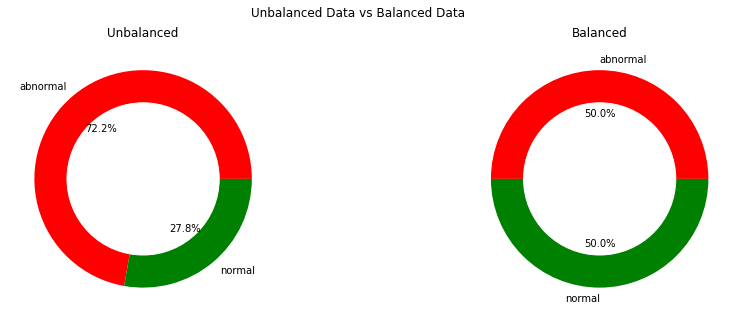

In [34]:
plt.figure(figsize=(15,5))
#unbalanced data plot
plt.subplot(1,2,1)
ptbdb_circle = plt.Circle( (0,0), 0.7, color='white')
plt.pie(equilibre, labels=['abnormal', 'normal'], colors=['red', 'green'], autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(ptbdb_circle)
plt.title("Unbalanced")
#balanced data plot
plt.subplot(1,2,2)
ptbdb_circle = plt.Circle( (0,0), 0.7, color='white')
plt.pie(resampled, labels=['abnormal', 'normal'], colors=['red', 'green'], autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(ptbdb_circle)
plt.title("Balanced")

plt.suptitle("Unbalanced Data vs Balanced Data")
plt.show()

In [46]:
#Train and test sets for the ANN
X_train = X[:5600]
X_test = X[5600:]

#data for the convolutional nets that needs to be reshaped
Xc = np.asarray(X)
Xc = Xc.reshape(8000,187,1)
 
Xc_train = Xc[:5600]
Xc_test = Xc[5600:]

#label data that is universally applicable
y_train = y[:5600]
y_test = y[5600:]

print(X_train.shape)

(5600, 187)


In [0]:
#train and test sets for the ANN
X_up_train = X_up[:14000]
X_up_test = X_up[14000:]

#data for the convolutional nets that needs to be reshaped
Xc_up = np.asarray(X_up)
Xc_up = Xc_up.reshape(20000,187,1)

Xc_up_train = Xc_up[:14000]
Xc_up_test = Xc_up[14000:]

#label data that is universally applicable
y_up_train = y_up[:14000]
y_up_test = y_up[14000:]

In [0]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

y_up_train = to_categorical(y_up_train)
y_up_test = to_categorical(y_up_test)

# **Basic deep neural network to establish a baseline accuracy**

In [48]:
model_1 = Sequential()
model_1.add(Dense(100, input_dim=187, activation='relu'))
model_1.add(Dense(100, activation='relu'))
model_1.add(Dense(90, activation='relu' ))
model_1.add(Dense(70, activation='relu'))
model_1.add(Dense(2, activation='sigmoid'))

print(model_1.summary())
model_1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 100)               18800     
_________________________________________________________________
dense_22 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_23 (Dense)             (None, 90)                9090      
_________________________________________________________________
dense_24 (Dense)             (None, 70)                6370      
_________________________________________________________________
dense_25 (Dense)             (None, 2)                 142       
Total params: 44,502
Trainable params: 44,502
Non-trainable params: 0
_________________________________________________________________
None


In [49]:
print(X_train.shape)

(5600, 187)


In [50]:
callbacks = [EarlyStopping(monitor='val_loss', patience=2)]

history = model_1.fit(X_train, y_train, validation_data=(X_test, y_test), callbacks=callbacks ,epochs=100, batch_size=32)


Train on 5600 samples, validate on 2400 samples
Epoch 1/100
5600/5600 [==============================] - 3s 459us/step - loss: 0.4940 - accuracy: 0.7707 - val_loss: 0.4079 - val_accuracy: 0.8277
Epoch 2/100
5600/5600 [==============================] - 1s 140us/step - loss: 0.3622 - accuracy: 0.8542 - val_loss: 0.3509 - val_accuracy: 0.8540
Epoch 3/100
5600/5600 [==============================] - 1s 140us/step - loss: 0.3002 - accuracy: 0.8767 - val_loss: 0.3084 - val_accuracy: 0.8621
Epoch 4/100
5600/5600 [==============================] - 1s 143us/step - loss: 0.2521 - accuracy: 0.8991 - val_loss: 0.2704 - val_accuracy: 0.8890
Epoch 5/100
5600/5600 [==============================] - 1s 138us/step - loss: 0.2233 - accuracy: 0.9148 - val_loss: 0.2370 - val_accuracy: 0.9112
Epoch 6/100
5600/5600 [==============================] - 1s 140us/step - loss: 0.2043 - accuracy: 0.9209 - val_loss: 0.2287 - val_accuracy: 0.9190
Epoch 7/100
5600/5600 [==============================] - 1s 140us/ste

2400/2400 [==============================] - 0s 48us/step
Model Accuracy: 93.00%


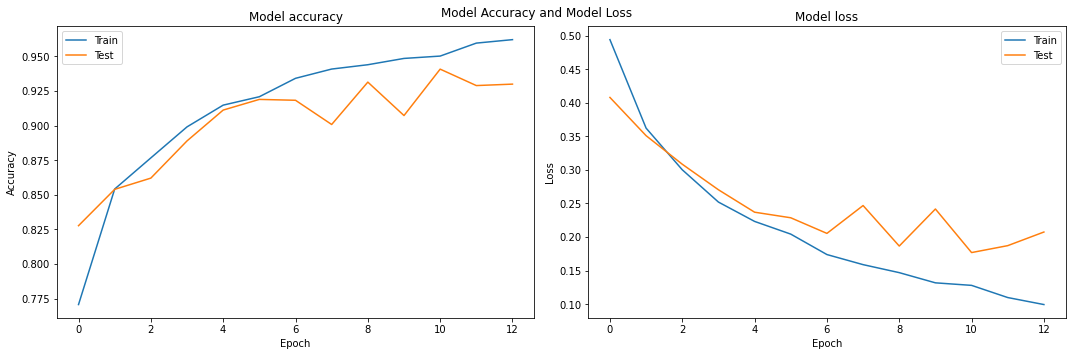

In [52]:
test = X_test
model = model_1
model_evalutation(history, test, y_test, model)

              precision    recall  f1-score   support

           0       0.96      0.90      0.93      1208
           1       0.90      0.96      0.93      1192

    accuracy                           0.93      2400
   macro avg       0.93      0.93      0.93      2400
weighted avg       0.93      0.93      0.93      2400



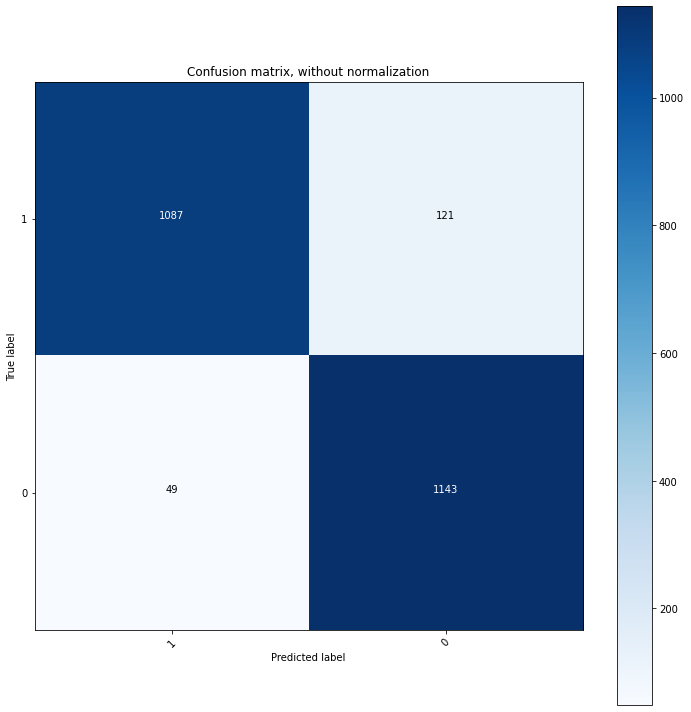

In [53]:
y_pred = model_1.predict(X_test, batch_size=1000)
print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=['1','0'],
                      title='Confusion matrix, without normalization')
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


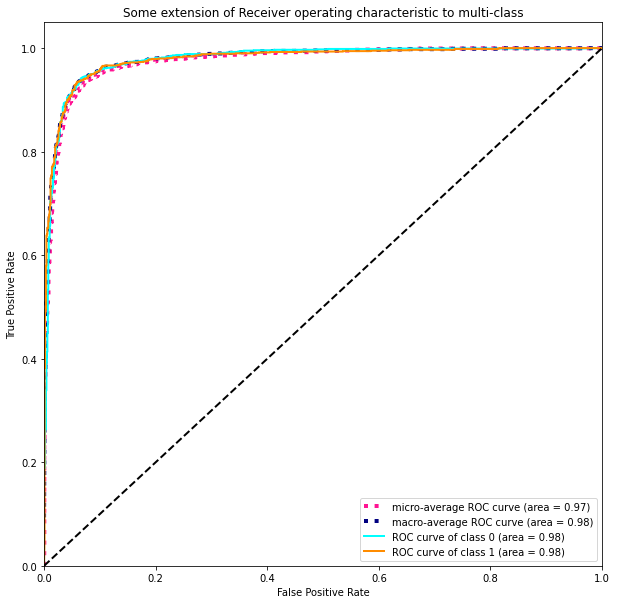

In [55]:
y = y
y_pred = model_1.predict(X_test, batch_size=1000)
y_test = y_test

roc_curve_evaluation(y, y_pred, y_test)

# **Orginal convolutional neural network**

In [0]:
model_1 = Sequential()
model_1.add(Convolution1D(100, 5, activation='relu', input_shape=(187, 1)))
model_1.add(Convolution1D(110, 5, activation='relu'))
model_1.add(Convolution1D(120, 5, activation='relu'))
model_1.add(MaxPooling1D(3))
model_1.add(Convolution1D(140, 10, activation='relu'))
model_1.add(Convolution1D(150, 10, activation='relu'))
model_1.add(Convolution1D(160, 10, activation='relu'))
model_1.add(Convolution1D(170, 10, activation='relu'))
model_1.add(Convolution1D(200, 10, activation='relu'))
model_1.add(GlobalAveragePooling1D())
model_1.add(Dropout(0.5))
model_1.add(Dense(100, activation='relu'))
model_1.add(Dense(50, activation='relu' ))
model_1.add(Dense(2, activation='softmax'))

print(model_1.summary())
model_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
callbacks = [EarlyStopping(monitor='val_loss', patience=5)]

history = model_1.fit(Xc_train, label_train, validation_data=(Xc_test, label_test), callbacks=callbacks, epochs=40, batch_size= 32)

In [0]:
test = Xc_test
y_test = label_test
model = model_1
model_evalutation(history, test, y_test, model)

In [0]:
y_pred = model_1.predict(Xc_test, batch_size=1000)
print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=['0','1'],
                      title='Confusion matrix, without normalization')
plt.show()


In [0]:
y = y 
y_pred = model_1.predict(Xc_test, batch_size=1000)
y_test = label_test

roc_curve_evaluation(y, y_pred, y_test)

In [0]:
callbacks = [EarlyStopping(monitor='val_loss', patience=5)]

history = model_1.fit(Xc_up_train, y_up_train, validation_data=(Xc_up_test, y_up_test), callbacks=callbacks, epochs=40, batch_size= 32)

In [0]:
test = Xc_up_test
y_test = y_up_test
model = model_1
model_evalutation(history, test, y_test, model)

In [0]:
y_pred = model_1.predict(Xc_up_test, batch_size=1000)
print(classification_report(y_up_test.argmax(axis=1), y_pred.argmax(axis=1)))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_up_test.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=['0','1'],
                      title='Confusion matrix, without normalization')
plt.show()

# **Well known convolutional neural network for comparison purposes**

In [0]:
model_2 = Sequential()
model_2.add(Convolution1D(6, 3, activation='relu', input_shape=(187, 1), padding='same'))
model_2.add(AveragePooling1D(2))
model_2.add(Convolution1D(16, 3, activation='relu', padding='valid'))
model_2.add(AveragePooling1D(2))
model_2.add(Flatten())
model_2.add(Dense(120, activation='relu'))
model_2.add(Dense(84, activation='relu'))
model_2.add(Dense(2, activation='softmax'))

print(model_2.summary())
model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
callbacks = [EarlyStopping(monitor='val_loss', patience=8)]

history = model_2.fit(Xc_train, label_train, validation_data=(Xc_test, label_test), callbacks=callbacks , epochs=40, batch_size= 32)

In [0]:
test = Xc_test
model = model_2
model_evalutation(history, test, y_test, model)

In [0]:
y_pred = model_2.predict(Xc_test, batch_size=1000)
print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=['0','1'],
                      title='Confusion matrix, without normalization')
plt.show()

In [0]:
y = y
y_pred = model_2.predict(Xc_test, batch_size=1000)
y_test = label_test

roc_curve_evaluation(y, y_pred, y_test)

# **Original Recurrent neural network**

In [0]:
im_shape=(Xc_train.shape[1],1)

model_5= Sequential()
model_5.add(Dense(32,W_regularizer=regularizers.l2(l=0.01), input_shape=im_shape))
model_5.add(Bidirectional(LSTM(64, return_sequences=True))) #, input_shape=(seqlength, features)) ) ### bidirectional ---><---
model_5.add(Dense(32,W_regularizer=regularizers.l2(l=0.01), input_shape=im_shape))
model_5.add(Bidirectional(LSTM(64, return_sequences=True)))
model_5.add(Dropout(0.2))
model_5.add(Dense(32,W_regularizer=regularizers.l2(l=0.01), input_shape=im_shape))
model_5.add(Bidirectional(LSTM(64, return_sequences=True)))
model_5.add(Dense(32,W_regularizer=regularizers.l2(l=0.01), input_shape=im_shape))
model_5.add(Bidirectional(LSTM(64, return_sequences=True)))
model_5.add(Dropout(0.2))
model_5.add(BatchNormalization())
model_5.add(Dense(64, activation='relu',W_regularizer=regularizers.l2(l=0.01)))
model_5.add(Dense(64, activation='relu',W_regularizer=regularizers.l2(l=0.01)))
model_5.add(Dropout(0.2))
model_5.add(BatchNormalization())
model_5.add(Dense(64, activation='relu',W_regularizer=regularizers.l2(l=0.01)))
model_5.add(Dense(32, activation='relu',W_regularizer=regularizers.l2(l=0.01)))
model_5.add(Dense(2, activation='relu',W_regularizer=regularizers.l2(l=0.01)))
model_5.add(Flatten())
model_5.add(Dense(2, activation='sigmoid'))


adam = optimizers.adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model_5.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy']) 
print(model_5.summary())

In [0]:
callbacks = [EarlyStopping(monitor='val_loss', patience=5)]
history=model_5.fit(Xc_train, y_train,epochs=40,callbacks=callbacks, batch_size=32,validation_data=(Xc_test,y_test))

In [0]:
test = Xc_test
model = model_5
model_evalutation(history, test, y_test, model)

In [0]:
y_pred = model_5.predict(Xc_test, batch_size=1000)
print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=['1','0'],
                      title='Confusion matrix, without normalization')
plt.show()

In [0]:
y = y
y_pred = model_5.predict(Xc_test, batch_size=1000)
y_test = label_test

roc_curve_evaluation(y, y_pred, y_test)